In [1]:
# Operator Learning via Kernel Methods
#
# This is mostly a script for prototyping methods

In [2]:
# Imports
import numpy as np
import sklearn as skl
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.kernel_ridge import KernelRidge
import sys
sys.path.append('./')
from KLearn import *
from functools import reduce
from scipy import integrate
import matplotlib.pyplot as plt

In [3]:
# Define some Kernels
γ = 50;
K = lambda y1,y2 : rbf_kernel(y1,y2, gamma = γ)
S = lambda x1,x2 : rbf_kernel(x1.T,x2.T, gamma = 0.00001) # lame, for now

In [97]:
### Generating Data

## GP kernel

def gp_kernel(t,σ):
  return np.exp( - (1/(2*σ**2))*t**2)

N_mesh = 200
a = 0
b = 1
x = np.linspace(a,b, N_mesh) # fine grid for visualization
dx = (b-a)/N_mesh

## compute pairwise distance matrix

dist_matrix = pairwise_distances( x.reshape(-1,1), x.reshape(-1,1))

## GP lengthscale
σ = 0.1
Cov_matrix = gp_kernel(dist_matrix, σ) + 1e-8*np.eye(N_mesh)
Cov_matrix = 1/2*(Cov_matrix + Cov_matrix.T)

Cov_matrix_sqrt = np.linalg.cholesky(Cov_matrix)

In [125]:
## Training and test functions

N_train = 1000    # Number of training functions
N_test  = 1     # Number of testing functions
u_train = np.zeros((N_mesh, N_train))
u_test  = np.zeros((N_mesh, N_test))

for i in range(N_train):
  xi = np.random.randn(N_mesh)
  u_train[:, i] = np.dot(Cov_matrix_sqrt, xi)

for i in range(N_test):
  xi = np.random.randn(N_mesh)
  u_test [:, i] = np.dot(Cov_matrix_sqrt, xi)

# Define Operators
def comp_fxn(*fxn): 
      
    def comp(f, g): 
        return lambda x : f(g(x)) 
              
    return reduce(comp, fxn, lambda x : x) 

# Identity Operator (Linear)
def op_I(u):
    return u

# Scaling Operator (Linear)
def op_a(u):
    a = 10;
    return a*u

# Squaring Operator (Slightly Nonlinear)
def op_square(u):
    return u**2

# Sine Operator (Contractive)
def op_sin(u):
    return np.sin(u)

# Discrete Integration (Linear, Discrete)
def op_int(u,x,N_mesh,N):
    ints = np.zeros((np.shape(u)))
    idx = []
    for i in range(0, N_mesh):
        idx.append(i)
        ints[i][:] = integrate.simpson(u[idx][:], x[idx], axis = 0)
    return ints

# Discrete Double Integration
def op_int2(u,x,N_mesh,N):
    return op_int(op_int(u,x,N_mesh,N),x,N_mesh,N)

In [126]:
# Conv Operator
# def op_conv(u):
#    return signal.convolve2d(u.T, np.exp(-np.square(np.outer(x, np.ones(shape = np.shape(x)))).T), mode='same').T


# v_train = op_a(u_train)
# v_test = op_a(u_test)

# Integral Operators (Need Extra Inputs)
X = x.reshape((-1,1))
v_train = op_int(u_train,X,N_mesh,N_train)
v_test  = op_int(u_test,X,N_mesh,N_test)

In [127]:
# Finish setting up
U = u_train;
V = v_train;
Y = x.reshape((-1, 1));

In [128]:
# LEARN!
D,f = KLearn(U,V,N_mesh,S,K,Y)

In [129]:
# Does it work... ?
v_mod = D(u_test);
np.max(np.abs(v_mod(Y) - v_test)) # very nice...

3.6771156901926894e-05

In [130]:
# Define some Kernels again (this time, parameterized)
K_ = lambda g: (lambda y1,y2 : rbf_kernel(y1,y2, gamma = g))
S_ = lambda s : (lambda x1,x2 : rbf_kernel(x1,x2, gamma = s)) # lame, for now
kgrid = np.linspace(10,100, 100)
sgrid = 1/np.power(5,range(1,12))

In [131]:
# LEARN AGAIN!
D2,f2 = OpLearn(U,V, S_,sgrid, K_,kgrid,Y)

Optimal gamma = 1.024e-07


In [132]:
# Does it work... ?
v_mod2 = D2(u_test);

# L1 Error (Averaged over Each Test Function)
L1_err = dx*sum(np.abs(v_mod2(Y) - v_test))
L1_err_avg = np.average(L1_err)
print(L1_err_avg)

L1_err_rel = np.average(np.divide(L1_err, dx*sum(np.abs(v_test))))

# L2 Error (Averaged over Each Test Function)
L2_err = np.sqrt(dx*sum(np.square(np.abs(v_mod2(Y) - v_test))))
L2_err_avg = np.average(L2_err)
print(L2_err_avg)

L2_err_rel = np.average(np.divide(L2_err, np.sqrt(dx*sum(np.square(np.abs(v_test))))))

# L_inf Error (Total Matrix)
Linf_err = np.max(np.abs(v_mod2(Y) - v_test)) # very nice...
print(Linf_err)

Linf_err_rel = Linf_err/np.max(np.abs(v_test))

Optimal gamma = 36.36363636363636
1.0957056317572507e-05
1.2881772378789516e-05
3.710734579619873e-05


[Text(0.5, 0, 'x'),
 Text(0, 0.5, '$log(|v_i(x) - G(u_i(x))|/|v_i(x)|)$'),
 Text(0.5, 1.0, 'CV-trained Error (Relative)')]

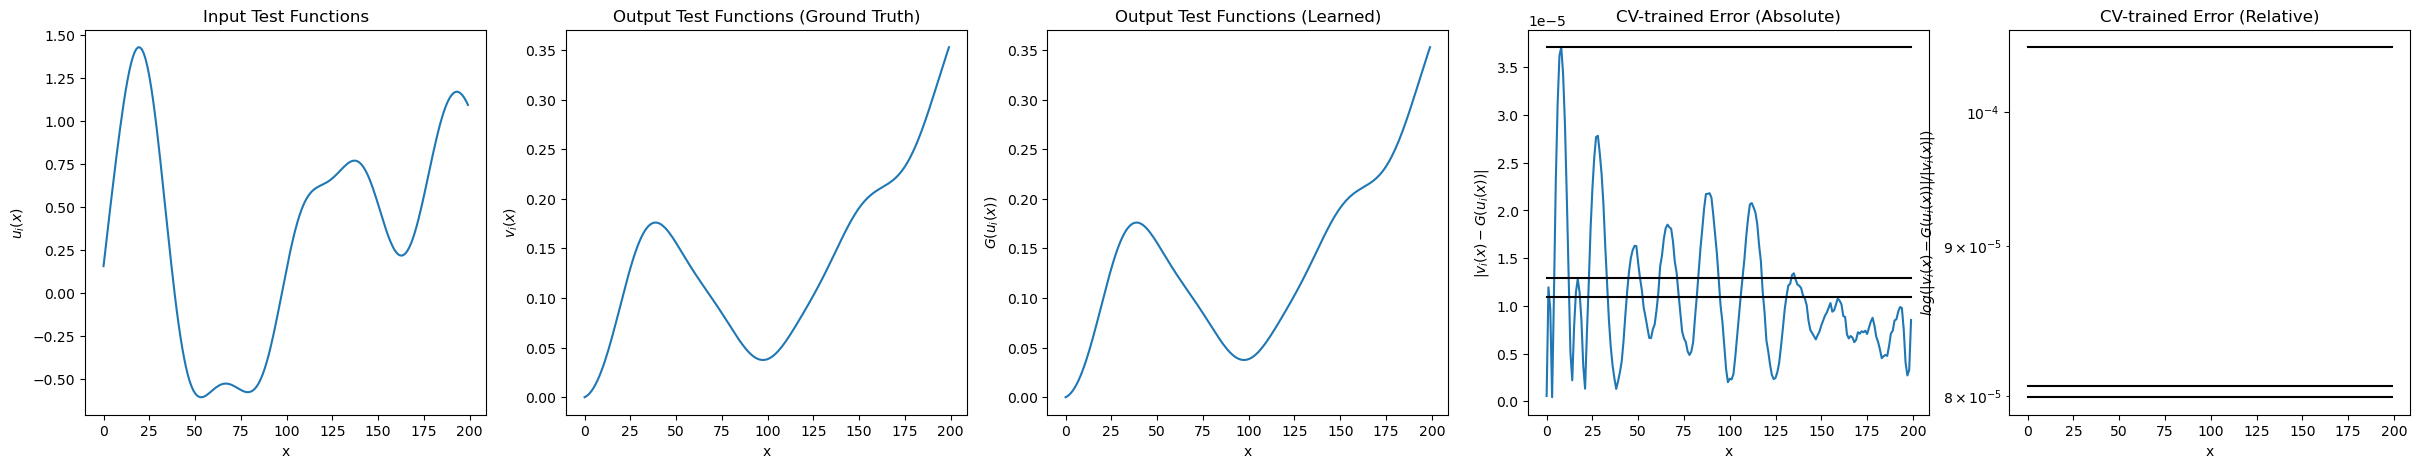

In [133]:
fig, ax = plt.subplots(1,5)

fig.set_size_inches(30,5)

ax[0].plot(u_test)
ax[0].set( xlabel ='x', ylabel='$u_i(x)$', title = "Input Test Functions")

ax[1].plot(v_test)
ax[1].set( xlabel ='x', ylabel='$v_i(x)$' , title = "Output Test Functions (Ground Truth)")

ax[2].plot(v_mod2(Y))
ax[2].set( xlabel ='x', ylabel='$G(u_i(x))$' , title = "Output Test Functions (Learned)")

ax[3].plot(abs(v_mod2(Y)-v_test))
ax[3].plot(L1_err_avg*np.ones(shape=np.shape(v_test)),color="black")
ax[3].plot(L2_err_avg*np.ones(shape=np.shape(v_test)),color="black")
ax[3].plot(Linf_err*np.ones(shape=np.shape(v_test)),color="black")
ax[3].set( xlabel ='x', ylabel='$|v_i(x) - G(u_i(x))|$' , title = "CV-trained Error (Absolute)")

# ax[4].semilogy(np.divide(abs(v_mod2(Y)-v_test),abs(v_test)))
ax[4].semilogy(L1_err_rel*np.ones(shape=np.shape(v_test)),color="black")
ax[4].semilogy(L2_err_rel*np.ones(shape=np.shape(v_test)),color="black")
ax[4].semilogy(Linf_err_rel*np.ones(shape=np.shape(v_test)),color="black")
ax[4].set( xlabel ='x', ylabel='$log(|v_i(x) - G(u_i(x))|/|v_i(x)|)$' , title = "CV-trained Error (Relative)")

In [ ]:
# A = np.array([[1,2,3],1])

In [ ]:
A = np.ones(shape=(20,30))

In [ ]:
from sklearn.model_selection import KFold
fldr = KFold(n_splits = 5) 
Afld = fldr.split(A)
for i, (train_index, test_index) in enumerate(Afld):
    print(train_index)
    print(np.shape(U[:,train_index]))

In [ ]:
kgrid = np.linspace(0,100, 100)